In [1]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4.1', temperature=0.0)

# 문서 떄려 박기(Stuff Docs)

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate


prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context': docs})

# 얘는 토큰을 많이 쓰니까 웬만하면 쓰지 말자~

In [5]:
from pprint import pprint

print(res)

아래는 해당 글의 핵심 내용을 집약한 요약입니다.

---

### LLM 기반 자율 에이전트 시스템 요약

#### 1. 개요
- LLM(대형 언어 모델)을 두뇌로 삼은 자율 에이전트는 복잡한 문제를 스스로 계획, 기억, 외부 도구와 연동하여 해결할 수 있다. AutoGPT, BabyAGI 등은 이러한 사례의 초기 시연 예시.

#### 2. 주요 구성 요소

1. **계획(Planning)**
    - **작업 분해:** Chain of Thought(연쇄적 사고), Tree of Thoughts(사고 트리) 등 프롬프트 기법을 통해 복잡한 문제를 작은 단계로 나눔.
    - **자기반성(Self-Reflection):** ReAct, Reflexion, Chain of Hindsight같은 기법으로 에이전트가 자신의 행동을 평가·수정, 지속적으로 향상함.

2. **기억(Memory)**
    - **유형:** 감각 기억(Embeddings), 단기 기억(프롬프트의 컨텍스트 창), 장기 기억(벡터 DB 등 외부 저장소).
    - **검색:** ANN, HNSW, FAISS, ScaNN 등 빠른 벡터 유사도 검색(MIPS) 기법 활용.

3. **도구 사용(Tool Use)**
    - LLM이 외부 API, 계산기, 검색 등 다양한 도구를 호출하여 한계 극복, MRKL, Toolformer, HuggingGPT 등 프레임워크 등장.
    - 케이스 스터디: 화학 연구(ChemCrow), 실험 기획, 가상 사회(Generative Agents) 등에서 우수한 활용 예시.

#### 3. 구현 사례
- **AutoGPT, GPT-Engineer:** LLM의 추론·자기반성, 작업 분해, API 호출, 파일 조작 등이 통합된 형태. 자연어로 목표를 제시하면 스스로 계획 수립과 단계별 실행.
- **Generative Agents:** LLM이 여러 가상의 에이전트를 통제하여 인간 유사 상호작용 및 사회행동 시뮬레이션.

#### 4. 도전과제
- 

## Map - Reduce

- 각각 나눠서 요약하기

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

In [9]:
# map(list(int, '12345'))

from functools import reduce

reduce_template = """
아래에 요약된 문서들이야.
{docs}
---
이것들을 가지고 정제해서 최종 통합본을 만들어줘.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [13]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

# Langgraph로 문서별 요약 작업 조율

In [14]:
# 문서를 더 작은 문서로 쪼개기
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 1000,
    chunk_overlap=0,
)

split_docs = text_splitter.split_documents(docs)

print(len(split_docs))

Created a chunk of size 1003, which is longer than the specified 1000


13


In [ ]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph

TOKEN_MAX = 1000

# 단일 상태가 아니라 전체 상태를 쓸 수 있음.
# 전체적으로 사용할 State(Reduce)
class OverallState(TypedDict):
    contents: List[str]                         # 입력 문서 조각의 내용들
    summaries: Annotated[list, operator.add]    # 각 contents의 요약본(노드들이 여러 개의 요약을 반환하면 자동으로 리스트 안에 합쳐짐)
    collapsed_summaries: List[Document]         # summaries를 document로 포장한 것들
    final_summary: str                          # 최종 요약본

# 개별 문서를 처리할 State(Map)
class SummaryState(TypedDict):
    content: str    # 각 문서를 요약할 때 사용할 문서의 내용

In [ ]:
map_prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용의 정확한 요약을 해 \n\n{context}')
])

# Node: 주어진 내용을 요약함.
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke({'context': state['content']})
    res = await llm.ainvoke(prompt)
    return {'summaries': [res.content]}
# 비동기 관련 async와 await, ainvoke

# Edge(router) -> 각 원본조각을 요약할 수 있게 generate_summary로 보냄(문서 조각 개수만큼)
def map_summaries(state: OverallState):
    
    result = []
    for content in state['contents']:
        result.append(Send('generate_summary', {'content': content}))
    
    return  result


# Node: 위에서 생성한 요약들을 Document() 객체로 만들어서 'collapsed_summaries' 키에 넣어줌
def collect_summaries(state: OverallState):
       return{
            'collapsed_summaries': [Document(summary) for summary in state['summaries']]
       }

# 1차 요약이 끝났는데, 요약본의 토큰 수가 너무 많은 건 어떻게 해야하지? 
# 필요에 따라 더 작은 요약으로 줄여야(collapse) 해.

async def collapse_summaries(state: OverallState):
     pass




split_list_of_docs(
     [Document('aaa'), Document('This is a loooooooong word')]
)
     

In [28]:
graph = StateGraph(OverallState)

graph.add_node('generate_summary', generate_summary)
graph.add_node('collect_summaries', collect_summaries)

graph.add_conditional_edges(START, map_summaries, ['generate_summary'])

graph.add_edge('generate_summary', 'collect_summaries')



app = graph.compile()

In [29]:
# 비동기: 병렬로 실행됨.

async for step in app.astream(
    {'contents': [doc.page_content for doc in split_docs]}
):
    print(step)



{'generate_summary': {'summaries': ['아래 내용에 대한 정확한 요약입니다.\n\n내용 요약:  \n주어진 명령어(Command)는 특정 작업(검색, 파일 관리, 코드 분석, 이미지 생성 등)을 자동화하고 효율적으로 수행하기 위한 리스트입니다. 각 명령어는 고유의 번호, 이름, 사용 방법, 목적을 포함합니다. 또한, 주어진 리소스(인터넷, 장기 메모리, GPT-3.5 에이전트, 파일 출력)와 스스로 성능을 평가하면서 효율적이고 실수 없는 행동을 하라는 지침이 포함되어 있습니다. 모든 행동에 비용이 있으므로 최소한의 단계로 목표를 달성하도록 요구합니다.']}}
{'generate_summary': {'summaries': ['요약:\n\n위 대화 내용은 코드를 작성하는 AI(어시스턴트)가 코드 아키텍처 설계 및 구현 방법에 대한 지침을 받고, 이후 구체적으로 단계별로 필요한 핵심 클래스, 함수, 메서드 이름과 용도 설명, 그리고 각 파일의 전체 코드를 마크다운 코드블록 형식에 맞춰 출력해야 함을 안내하고 있습니다. 기본적으로 "MVC(모델-뷰-컨트롤러)" 아키텍처 가정을 가지고 게임 예제를 예로 들어, 모델(데이터 및 상태), 뷰(시각적 표시), 컨트롤러(입력 처리 및 상태 갱신)로 역할을 나누겠다는 입장을 명확히 했고, 모든 파일을 완전하게 작성하고 의존성, 베스트프랙티스, 주석, 테스트, 파일간 완전한 호환성을 갖춰야 한다고 반복적으로 강조합니다.\n\n즉, 단계별로 아키텍처의 전체 구조를 정의하고, 그에 따라 모든 코드와 구조를 완전하게 작성해 제시하라는 목적과 절차가 요약의 핵심입니다.']}}
{'generate_summary': {'summaries': ['{\n    "thoughts": {\n        "text": "GPT-Engineer is a project that generates an entire code repository based on a natural language task and asks users

In [23]:
res = await app.ainvoke(
    {'contents': [doc.page_content for doc in split_docs]}
)
# 나눈 페이지 전부 동시에 수행됨.

print(res)

{'contents': ["LLM Powered Autonomous Agents | Lil'Log\n\nLil'Log\n\n|\n\n\nPosts\n\n\nArchive\n\n\nSearch\n\n\nTags\n\n\nFAQ\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent 

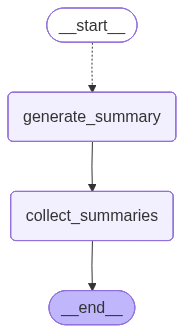

In [30]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())